In [333]:
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from glob import glob
import math
import json

In [248]:
from neuroCombat import neuroCombat, neuroCombatFromTraining

In [249]:
sys.path.insert(0, '/home/ROBARTS/myousif/software/PCNtoolkit/')
from pcntoolkit.util.utils import create_design_matrix

/home/ROBARTS/myousif/virtualenvs/pcntoolkit_dev_cbs_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
sys.path.insert(0, '/home/ROBARTS/myousif/software/hippomaps/')
import hippomaps as hm

In [2]:
project_dir = '/home/ROBARTS/myousif/projects_inprogress/hippocharts/'
project_data_dir = os.path.join(project_dir,'data')

In [58]:
thickness_data_df= pd.read_csv(os.path.join(project_data_dir,'thickness_participants_data.csv'),index_col=0)
gyr_data_df= pd.read_csv(os.path.join(project_data_dir,'gyrification_participants_data.csv'),index_col=0)
myelin_data_df= pd.read_csv(os.path.join(project_data_dir,'myelin_participants_data.csv'),index_col=0)
fa_data_df= pd.read_csv(os.path.join(project_data_dir,'FA_participants_data.csv'),index_col=0)
md_data_df= pd.read_csv(os.path.join(project_data_dir,'MD_participants_data.csv'),index_col=0)


In [53]:
def load_resample_metric(paths, in_den='0p5mm', out_den='2mm', resample=True):
    IDP = []

    for idp_path in paths:
        idpL, idpR = np.split(nib.load(idp_path).get_fdata(),2,axis=1)
        if resample:
            idpL_2mm = hm.utils.density_interp('0p5mm','2mm',idpL.T,'hipp')[0]
            idpR_2mm = hm.utils.density_interp('0p5mm','2mm',idpR.T,'hipp')[0]
            IDP.append(np.concatenate([idpL_2mm,idpR_2mm]).flatten())
        else:
            IDP.append(np.concatenate([idpL.T,idpR.T]).flatten())


    return np.stack(IDP)


In [55]:
thickness_IDP = load_resample_metric(thickness_data_csv.paths)

In [56]:
gyr_IDP = load_resample_metric(gyr_data_df.paths)

In [57]:
myelin_IDP = load_resample_metric(myelin_data_df.paths)

In [59]:
fa_IDP = load_resample_metric(fa_data_df.paths)

In [60]:
md_IDP = load_resample_metric(md_data_df.paths)

In [113]:
extreme = (np.abs((thickness_IDP.mean(axis=1) - thickness_IDP.mean())/thickness_IDP.std())>1)

<AxesSubplot: ylabel='Count'>

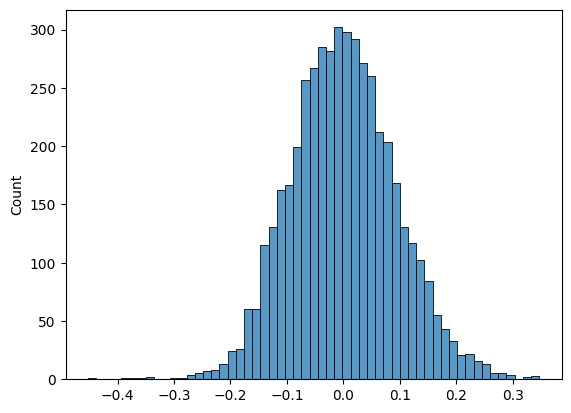

In [116]:
sns.histplot((thickness_IDP.mean(axis=1) - thickness_IDP.mean())/thickness_IDP.std())

<AxesSubplot: ylabel='Count'>

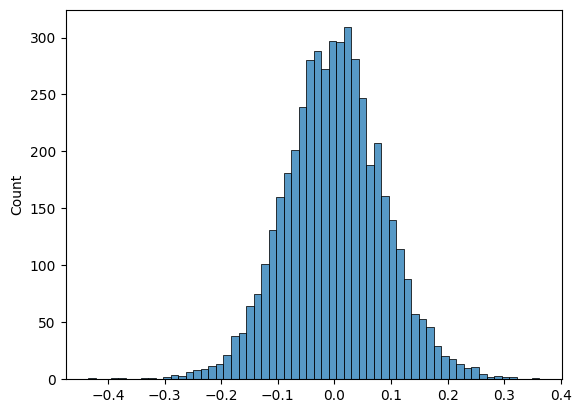

In [117]:
sns.histplot((gyr_IDP.mean(axis=1) - gyr_IDP.mean())/gyr_IDP.std())

In [132]:
myelin_df_zscore = myelin_data_df.copy()
myelin_df_zscore['z-score'] =(myelin_IDP.mean(axis=1) - myelin_IDP.mean())/myelin_IDP.std()

<AxesSubplot: xlabel='z-score', ylabel='Count'>

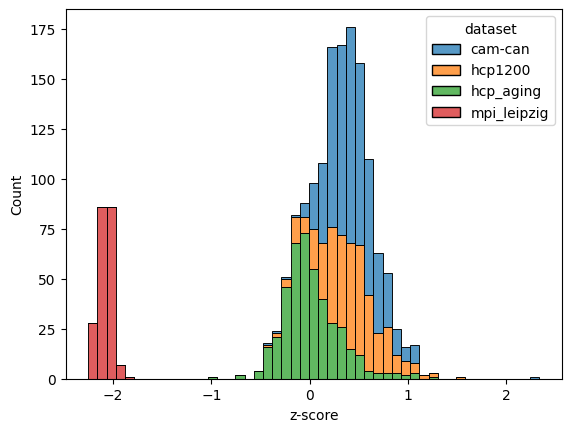

In [135]:
sns.histplot(data=myelin_df_zscore, x='z-score', hue='dataset',multiple='stack')

In [191]:
myelin_threshold = 1.75
myelin_extreme = ~((myelin_df_zscore['z-score']<np.negative(myelin_threshold)) | (myelin_df_zscore['z-score']>myelin_threshold))
myelin_IDP_clean = myelin_IDP[myelin_extreme]
myelin_df_clean = myelin_df_zscore[myelin_extreme]

<AxesSubplot: xlabel='z-score', ylabel='Count'>

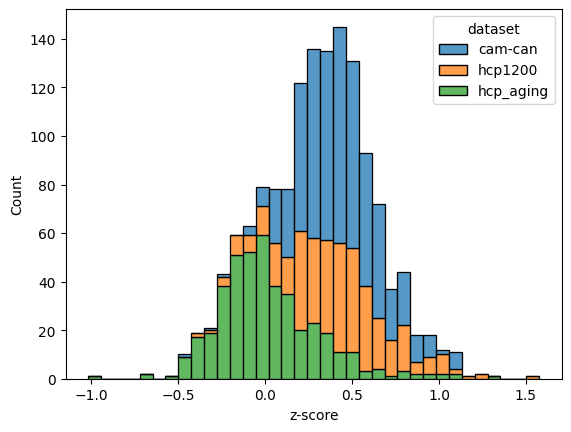

In [192]:
sns.histplot(data=myelin_df_clean,
             x='z-score',
             hue='dataset',
             multiple='stack')

In [136]:
fa_data_df_zscore = fa_data_df.copy()
fa_data_df_zscore['z-score'] = (fa_IDP.mean(axis=1) - fa_IDP.mean())/fa_IDP.std()

In [215]:
fa_threshold = 1.4
fa_not_extreme = ~((fa_data_df_zscore['z-score']<np.negative(fa_threshold)) | (fa_data_df_zscore['z-score']>fa_threshold))
fa_IDP_clean = fa_IDP[fa_not_extreme]
fa_data_df_clean = fa_data_df_zscore[fa_not_extreme].reset_index(drop=True)

<AxesSubplot: xlabel='z-score', ylabel='Count'>

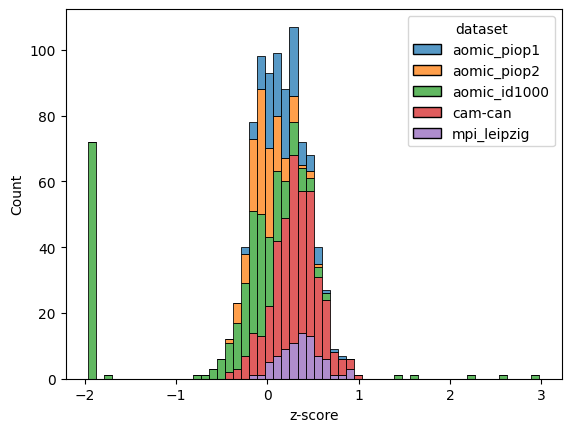

In [216]:
sns.histplot(data=fa_data_df_zscore, 
             x='z-score', 
             hue='dataset',
             multiple='stack')

<AxesSubplot: xlabel='z-score', ylabel='Count'>

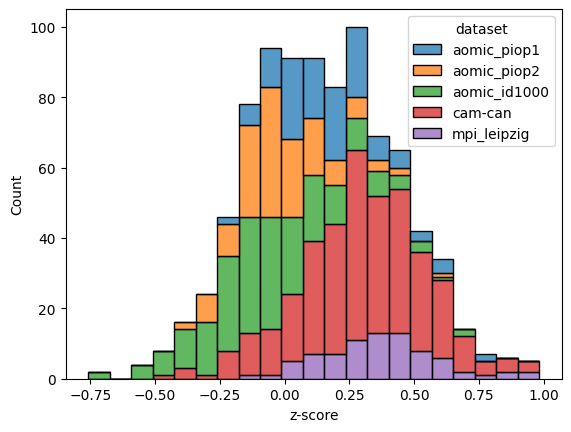

In [217]:
sns.histplot(data=fa_data_df_clean, 
             x='z-score', 
             hue='dataset',
             multiple='stack')

In [139]:
md_data_df_zscore = md_data_df.copy()
md_data_df_zscore['z-score'] = (md_IDP.mean(axis=1) - md_IDP.mean())/md_IDP.std()

<AxesSubplot: xlabel='z-score', ylabel='Count'>

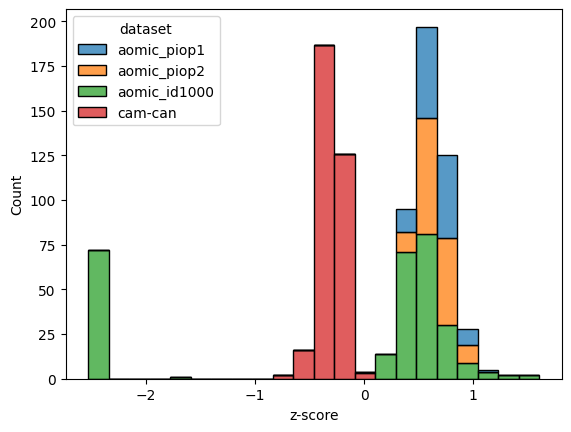

In [140]:
sns.histplot(data=md_data_df_zscore,x='z-score',hue='dataset',multiple='stack')

In [201]:
md_threshold = 1.6
md_IDP_clean = md_IDP[~((md_data_df_zscore['z-score']<np.negative(md_threshold)) | (md_data_df_zscore['z-score']>md_threshold))]
md_data_df_clean = md_data_df_zscore[~((md_data_df_zscore['z-score']<np.negative(md_threshold)) | (md_data_df_zscore['z-score']>md_threshold))]

<AxesSubplot: xlabel='z-score', ylabel='Count'>

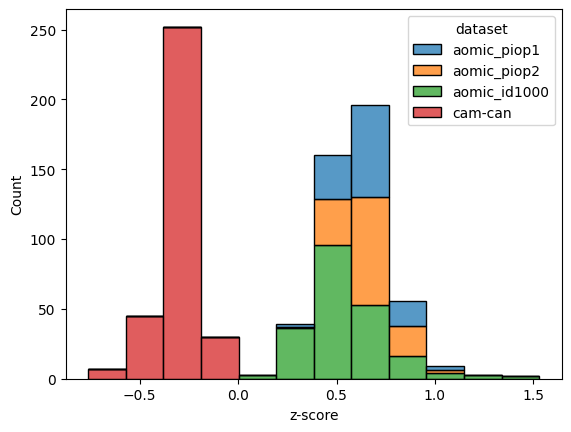

In [202]:
sns.histplot(data=md_data_df_clean,
             x='z-score',
             hue='dataset',
             multiple='stack')

<AxesSubplot: xlabel='age'>

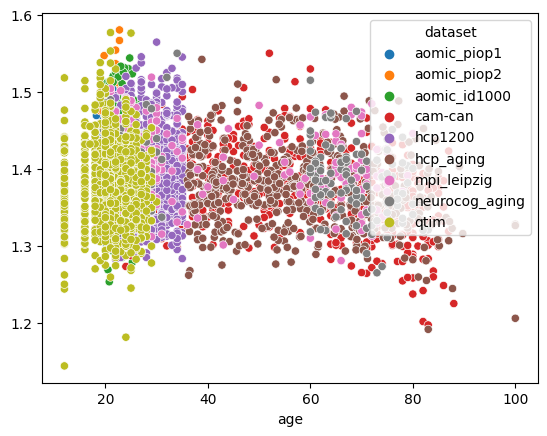

In [131]:
sns.scatterplot(x=thickness_data_df.age,y=thickness_IDP.mean(axis=1),hue=thickness_data_df.dataset)

<AxesSubplot: xlabel='age'>

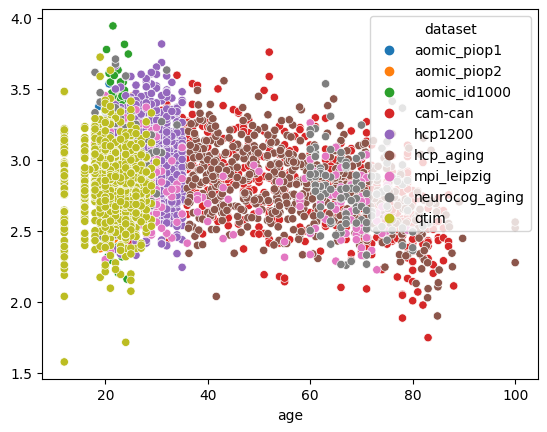

In [92]:
sns.scatterplot(x=gyr_data_df.age,y=gyr_IDP.mean(axis=1),hue=gyr_data_df.dataset)

<AxesSubplot: xlabel='age'>

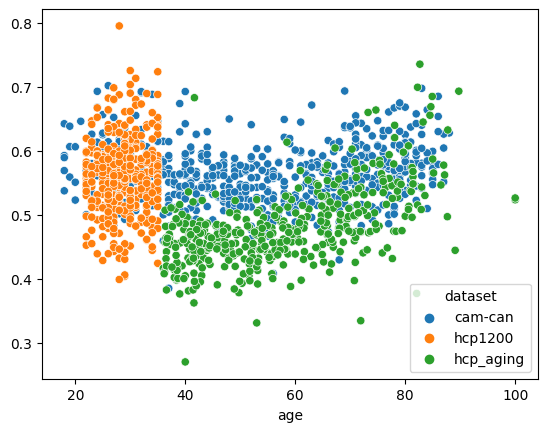

In [193]:
sns.scatterplot(x=myelin_df_clean.age,y=myelin_IDP_clean.mean(axis=1),hue=myelin_df_clean.dataset)

In [194]:
myelin_combat = neuroCombat(myelin_IDP_clean.T,
                          covars=myelin_df_clean,
                          batch_col='site',
                          categorical_cols=['sex'])

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


<AxesSubplot: xlabel='age'>

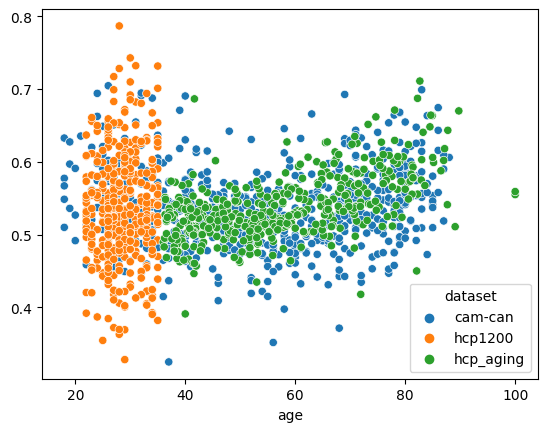

In [196]:
sns.scatterplot(x=myelin_df_clean.age,y=myelin_combat['data'].T.mean(axis=1),hue=myelin_df_clean.dataset)

<AxesSubplot: xlabel='age'>

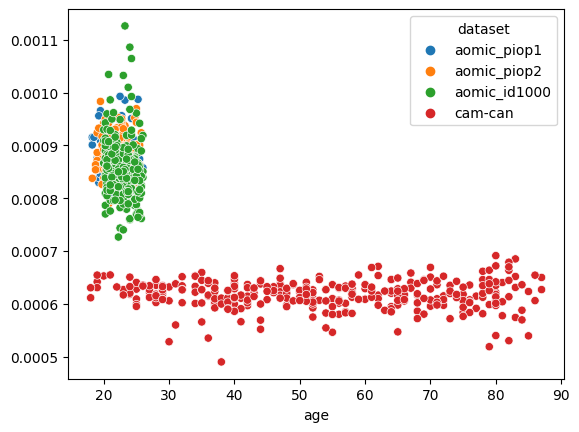

In [203]:
sns.scatterplot(x=md_data_df_clean.age,y=md_IDP_clean.mean(axis=1),hue=md_data_df_clean.dataset)

In [204]:
md_combat = neuroCombat(md_IDP_clean.T,
                          covars=md_data_df_clean,
                          batch_col='site',
                          categorical_cols=['sex'])

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


<AxesSubplot: xlabel='age'>

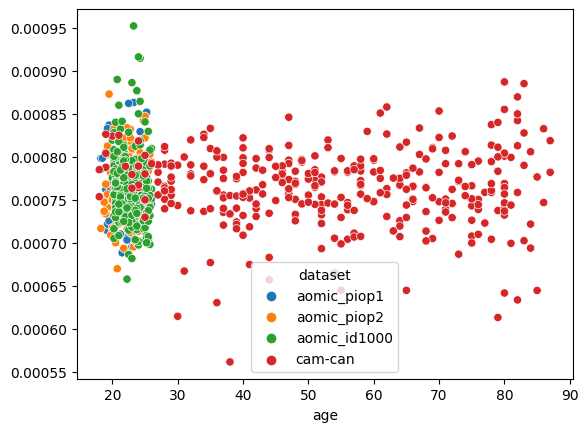

In [205]:
sns.scatterplot(x=md_data_df_clean.age,y=md_combat['data'].T.mean(axis=1),hue=md_data_df_clean.dataset)

<AxesSubplot: xlabel='age'>

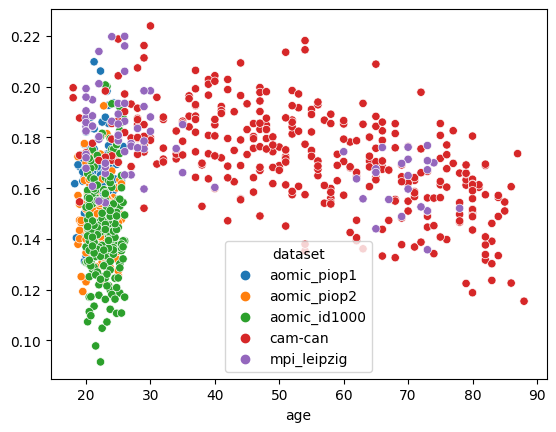

In [211]:
sns.scatterplot(x=fa_data_df_clean.age,y=fa_IDP_clean.mean(axis=1),hue=fa_data_df_clean.dataset)

In [226]:
fa_combat = neuroCombat(fa_IDP_clean.T,
                        covars=fa_data_df_clean,
                        batch_col='site',
                        categorical_cols=['sex'])

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


<AxesSubplot: xlabel='age'>

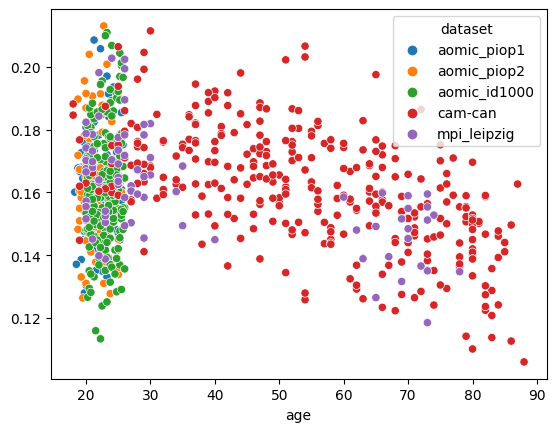

In [230]:
sns.scatterplot(x=fa_data_df_clean.age,
                y=fa_combat['data'].T.mean(axis=1),
                hue=fa_data_df_clean.dataset)

In [89]:
np.savetxt(os.path.join(project_data_dir,'thickness_den-2mm_IDP.txt'),thickness_IDP)
np.savetxt(os.path.join(project_data_dir,'gyrification_den-2mm_IDP.txt'),gyr_IDP)
np.savetxt(os.path.join(project_data_dir,'myelin_den-2mm_IDP.txt'),myelin_IDP)
np.savetxt(os.path.join(project_data_dir,'fa_den-2mm_IDP.txt'),fa_IDP)
np.savetxt(os.path.join(project_data_dir,'md_den-2mm_IDP.txt'),md_IDP)


In [239]:
myelin_df_clean.to_csv(os.path.join(project_data_dir,'myelin_participants_thresholded_zscore-1p75_data.csv'))
fa_data_df_clean.to_csv(os.path.join(project_data_dir,'fa_participants_thresholded_zscore-1p4_data.csv'))
md_data_df_clean.to_csv(os.path.join(project_data_dir,'md_participants_thresholded_zscore-1p6_data.csv'))

In [235]:
np.savetxt(os.path.join(project_data_dir,'myelin_den-2mm_desc-thresholded_zscore-1p75_IDP.txt'),myelin_IDP_clean)
np.savetxt(os.path.join(project_data_dir,'fa_den-2mm_desc-thresholded_zscore-1p4_IDP.txt'),fa_IDP_clean)
np.savetxt(os.path.join(project_data_dir,'md_den-2mm_desc-thresholded_zscore-1p6_IDP.txt'),md_IDP_clean)

In [261]:
metric_dfs = [thickness_data_df,gyr_data_df,myelin_df_clean,fa_data_df_clean,md_data_df_clean]

In [262]:
for met_df in metric_dfs:
    met_df['sex_code'] = met_df.sex.astype('category').cat.codes
    met_df['site_code'] = met_df.site.astype('category').cat.codes

/tmp/ipykernel_10942/2925276351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_df['sex_code'] = met_df.sex.astype('category').cat.codes
/tmp/ipykernel_10942/2925276351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_df['site_code'] = met_df.site.astype('category').cat.codes
/tmp/ipykernel_10942/2925276351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [331]:
design_matricies = []
counter = 0
for met_df in metric_dfs:
    if counter < 3:
        X_bspline_sites = create_design_matrix(met_df[['age','sex_code']],
                                               xmin = 5,
                                               xmax = 105,
                                               site_ids=met_df['site_code'],
                                               all_sites=met_df['site_code'].unique())
    elif counter == 3:
        X_bspline_sites = create_design_matrix(met_df[['age','sex_code']],
                                               xmin = 10,
                                               xmax = 105,
                                               site_ids=met_df['site_code'],
                                               all_sites=met_df['site_code'].unique())
    else:
        X_bspline_sites = create_design_matrix(met_df[['age','sex_code']],
                                               xmin = 10,
                                               xmax = 95,
                                               site_ids=met_df['site_code'],
                                               all_sites=met_df['site_code'].unique())
    design_matricies.append(X_bspline_sites)

In [342]:
for idx, met in enumerate(['thickness','gyrification','myelin','fa','md']):
    np.savetxt(os.path.join(project_data_dir,f'{met}_cov.txt'), design_matricies[idx])

In [343]:
for idx, met in enumerate(['thickness','gyrification','myelin','fa','md']):
    code_dict = {
        'sex':dict(zip(metric_dfs[idx].sex, metric_dfs[idx].sex_code)),
        'site':dict(zip(metric_dfs[idx].site, metric_dfs[idx].site_code))
    }
    with open(os.path.join(project_data_dir,f'{met}_category_var_codes.json'),'w') as outfile:
        json.dump(code_dict, outfile)